In [1]:
#default_exp ch1

# basic

The file wire.csv contains data relating the pull strength (pstren) of a wire bond (which we’ll treat as a response) to six characteristics which we shall treat as design variables: die height (dieh), post height (posth), loop height (looph), wire length (wlen), bond width on the die (diew), and bond width on the post (postw). (Derived from exercise 2.3 in Myers, Montgomery, and Anderson–Cook (2016) using data from Table E2.1.)

* Write code that converts natural variables in the file to coded variables in the unit hypercube. Also, normalize responses to have a mean of zero and a range of 1.
* Use model selection techniques to select a parsimonious linear model for the coded data including, potentially, second-order and interaction effects.
* Use the fitted model to make a prediction for pull strength, when the explanatory variables take on the values c(6, 20, 30, 90, 2, 2), in the order above, with a full accounting of uncertainty. Make sure the predictive quantities are on the original scale of the data.

In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [83]:
#hide
from nbdev.showdoc import *
import pandas as pd
import numpy as np
import plotnine as pn
from typing import List
from sklearn.linear_model import LinearRegression

In [439]:
def length(x: pd.Series):
    return np.sqrt(np.sum(np.square(x)))


def _predictor_to_unit_length(x: pd.Series) -> pd.Series:
    return x / length(x)


class DataManager:
    def __init__(self, response="postw", datafile="http://bobby.gramacy.com/surrogates/wire.csv"):
        self.data = pd.read_csv(datafile)
        self.data.columns = [s.strip() for s in self.data.columns]
        self.response: str = response
        self.predictors: List[str] = self._get_predictors()
        self.normalized = False

    
    def _get_predictors(self) -> List[str]:
        return [colname for colname in self.data.columns if colname != self.response]

    
    def predictors_to_hypercube(self):
        """ Scales each predictor to length 1. """
        for colname in self.predictors:
            self.data[colname] = _predictor_to_unit_length(self.data[colname])
            

    def normalize_response(self):
        """
        Scales the response to a mean of 0 and standard deviation of 1.
        """
        if self.normalized:
            return
        self.orig_mean = np.mean(self.data[self.response])
        self.orig_std = np.std(self.data[self.response])
        self.data[self.response] -= self.orig_mean
        self.data[self.response] /= self.orig_std
        self.normalized = True


    def make_quadratic_variables_wide(self) -> pd.DataFrame:
        """
        Returns a matrix with one column per variable combination, i.e.
        all the cross-multiplications. Also with one column per original variable.
        """
        interactions = {}
        for i, coli in enumerate(self.predictors):            
            interactions[coli] = self.data[coli]
            for j in range(i, len(self.predictors)):
                colj = self.predictors[j]
                interactions[f"{coli}*{colj}"] = self.data[coli] * self.data[colj]
        return pd.DataFrame(interactions)

    
    def make_quadratic_variables_long(self, wide=None):
        if wide is None:
            wide = self.make_quadratic_variables_wide()
        dfs = []
        idx = range(wide.shape[0])
        for colname in wide.columns:
            df = pd.DataFrame({'val': wide[colname]})
            df['var'] = colname
            df['response'] = self.data[self.response]
            dfs.append(df)
        return pd.concat(dfs)[['var', 'val', 'response']]


    def make_grid(self, x1_name, x2_name) -> pd.DataFrame:
        """
        Makes a dataframe with the columns (var, x1, x2, self.response),
        where var is some string variable combination (e.g. s * t), x1 is the value 
        of s, x2 is the value of t, and self.response is the value of the response
        at that actual s, t combination in the data.
        """
        df = self.data[[x1_name, x2_name, self.response]]
        df.columns = ['x1', 'x2', self.response]
        df['var'] = f"{x1_name}*{x2_name}"
        return df


    def make_grids(self) -> pd.DataFrame:
        """
        Applies make_grid for every variable combination in the data.
        """
        dfs = []
        icols = self.predictors
        for i in range(len(self.predictors)):
            dfs.append(self.make_grid(self.predictors[i], self.predictors[i]))
            for j in range(i - 1, len(self.predictors)):
                df = self.make_grid(self.predictors[i], self.predictors[j])
                dfs.append(df)
        return pd.concat(dfs)
    

    def get_linear_slopes(self, grids_df):
        """
        Returns a dataframe with each variable in grids_df, and the size
        of each linear slope when a predictor on only that variable
        is fit to this manager's data.
        """
        slope_rows = []
        for name, df in grids_df.groupby('var'):
            model = LinearRegression()
            X = pd.DataFrame(df['x1'] * df['x2']).values
            y = df[self.response].values
            model.fit(X, y)
            assert len(model.coef_) == 1
            slope = model.coef_[0]
            row = (name, slope)
            slope_rows.append(row)
            
        for name in self.predictors:
            df = grids_df[grids_df['var'] == f"{name}*{name}"]
            df = df.iloc[0:self.data.shape[0], :]
            
            if df.shape[0] != self.data.shape[0]:
                print(df)
                raise AssertionError(f"got {df.shape[0]} rows but expected {self.data.shape[0]}")
            X, y = pd.DataFrame(df['x1']).values, df[self.response].values
            model = LinearRegression().fit(X, y)            
            assert len(model.coef_) == 1
            slope_rows.append((name, model.coef_[0]))
        slopes_df = pd.DataFrame(slope_rows, columns=['var', 'slope'])
        slopes_df['abs_slope'] = slopes_df['slope'].abs()
        return slopes_df.sort_values('abs_slope', ascending=False)

    
wires_facet_theme = pn.theme(
    subplots_adjust={'hspace': 0.25}, 
    figure_size=(18, 15))

def plot_scatter(dat, figsize=(16, 12)):
    return (
        pn.ggplot(dat, pn.aes(x='val', y='response')) +
        pn.geom_point() +
        pn.geom_smooth(method='lm') +
        pn.facet_wrap("var", scales='free_x') +
        pn.theme_bw() +
        pn.theme(figure_size=figsize))

In [447]:
grids_df

,x1,x2,postw,var
0,0.179626,0.179626,2.116610,pstren*pstren
1,0.186362,0.186362,-0.884554,pstren*pstren
2,0.190852,0.190852,0.315912,pstren*pstren
3,0.197588,0.197588,0.916145,pstren*pstren
4,0.202079,0.202079,-0.884554,pstren*pstren
...,...,...,...,...
14,0.208905,0.208905,-0.884554,diew*diew
15,0.230895,0.230895,0.916145,diew*diew
16,0.219900,0.219900,-0.884554,diew*diew
17,0.230895,0.230895,-0.884554,diew*diew


In [382]:
grids_df['var'].unique()

array(['pstren*pstren', 'pstren*diew', 'pstren*dieh', 'pstren*posth',
       'pstren*looph', 'pstren*wlen', 'dieh*dieh', 'dieh*pstren',
       'dieh*posth', 'dieh*looph', 'dieh*wlen', 'dieh*diew',
       'posth*posth', 'posth*dieh', 'posth*looph', 'posth*wlen',
       'posth*diew', 'looph*looph', 'looph*posth', 'looph*wlen',
       'looph*diew', 'wlen*wlen', 'wlen*looph', 'wlen*diew', 'diew*diew',
       'diew*wlen'], dtype=object)

In [383]:
dm = DataManager()
dm.data.head()

,pstren,dieh,posth,looph,wlen,diew,postw
0,8.0,5.2,19.6,29.6,94.9,2.1,2.3
1,8.3,5.2,19.8,32.4,89.7,2.1,1.8
2,8.5,5.8,19.6,31.0,96.2,2.0,2.0
3,8.8,6.4,19.4,32.4,95.6,2.2,2.1
4,9.0,5.8,18.6,28.6,86.5,2.0,1.8


---------
### Write code that converts natural variables in the file to coded variables in the unit hypercube. Also, normalize responses to have a mean of zero and a range of 1.

In [384]:
dm.predictors_to_hypercube()
dm.normalize_response()
dm.data.head()

,pstren,dieh,posth,looph,wlen,diew,postw
0,0.179626,0.205221,0.231706,0.210582,0.245585,0.230895,2.116610
1,0.186362,0.205221,0.234071,0.230502,0.232129,0.230895,-0.884554
2,0.190852,0.228901,0.231706,0.220542,0.248950,0.219900,0.315912
3,0.197588,0.252580,0.229342,0.230502,0.247397,0.241890,0.916145
4,0.202079,0.228901,0.219884,0.203468,0.223848,0.219900,-0.884554


In [385]:
# Test data standardization.
for colname in dm.predictors:
    x = dm.data[colname]
    assert x.max() <= 1    
    assert x.min() >= 0
    1 - length(x) <= 10e-7

---------
### Use model selection techniques to select a parsimonious linear model for the coded data including, potentially, second-order and interaction effects.

In [386]:
quadratics_wide = dm.make_quadratic_variables_wide()
quadratics_long = dm.make_quadratic_variables_long(quadratics_wide)

In [387]:
quadratics_wide.head()

,pstren,pstren*pstren,pstren*dieh,pstren*posth,pstren*looph,pstren*wlen,pstren*diew,dieh,dieh*dieh,dieh*posth,...,posth*diew,looph,looph*looph,looph*wlen,looph*diew,wlen,wlen*wlen,wlen*diew,diew,diew*diew
0,0.179626,0.032265,0.036863,0.041620,0.037826,0.044113,0.041475,0.205221,0.042116,0.047551,...,0.053500,0.210582,0.044345,0.051716,0.048622,0.245585,0.060312,0.056704,0.230895,0.053312
1,0.186362,0.034731,0.038245,0.043622,0.042957,0.043260,0.043030,0.205221,0.042116,0.048036,...,0.054046,0.230502,0.053131,0.053506,0.053222,0.232129,0.053884,0.053597,0.230895,0.053312
2,0.190852,0.036425,0.043686,0.044222,0.042091,0.047513,0.041968,0.228901,0.052395,0.053038,...,0.050952,0.220542,0.048639,0.054904,0.048497,0.248950,0.061976,0.054744,0.219900,0.048356
3,0.197588,0.039041,0.049907,0.045315,0.045544,0.048883,0.047795,0.252580,0.063797,0.057927,...,0.055475,0.230502,0.053131,0.057025,0.055756,0.247397,0.061205,0.059843,0.241890,0.058511
4,0.202079,0.040836,0.046256,0.044434,0.041117,0.045235,0.044437,0.228901,0.052395,0.050332,...,0.048353,0.203468,0.041399,0.045546,0.044742,0.223848,0.050108,0.049224,0.219900,0.048356


In [388]:
if False:
    (pn.ggplot(grids_df, pn.aes(x='x1', y='x2', fill=dm.response)) +
     pn.geom_tile() +
     pn.facet_wrap("var", scales="free")  +
     pn.theme_bw() +
     wires_facet_theme)

In [407]:
grids_df = dm.make_grids()
grids_df.head()

<ipython-input-381-81536d8c79cf>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,x1,x2,postw,var
0,0.179626,0.179626,2.116610,pstren*pstren
1,0.186362,0.186362,-0.884554,pstren*pstren
2,0.190852,0.190852,0.315912,pstren*pstren
3,0.197588,0.197588,0.916145,pstren*pstren
4,0.202079,0.202079,-0.884554,pstren*pstren


In [434]:
slopes_df = dm.get_linear_slopes(grids_df)
slopes_df

,var,slope,abs_slope
7,diew*wlen,112.644658,112.644658
23,wlen*diew,112.644658,112.644658
6,diew*diew,86.730456,86.730456
13,posth*diew,83.345167,83.345167
2,dieh*looph,-83.166397,83.166397
16,posth*wlen,78.975079,78.975079
25,wlen*wlen,72.345375,72.345375
0,dieh*dieh,-54.989607,54.989607
3,dieh*posth,-47.623268,47.623268
12,posth*dieh,-47.623268,47.623268


In [435]:
plot_vars = quadratics_wide.columns
plot_df = quadratics_long[quadratics_long['var'].apply(lambda s: s in plot_vars)]
plot_df['var'] = pd.Categorical(plot_df['var'], categories=slopes_df['var'])

/opt/conda/lib/python3.8/site-packages/plotnine/facets/facet.py:555: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


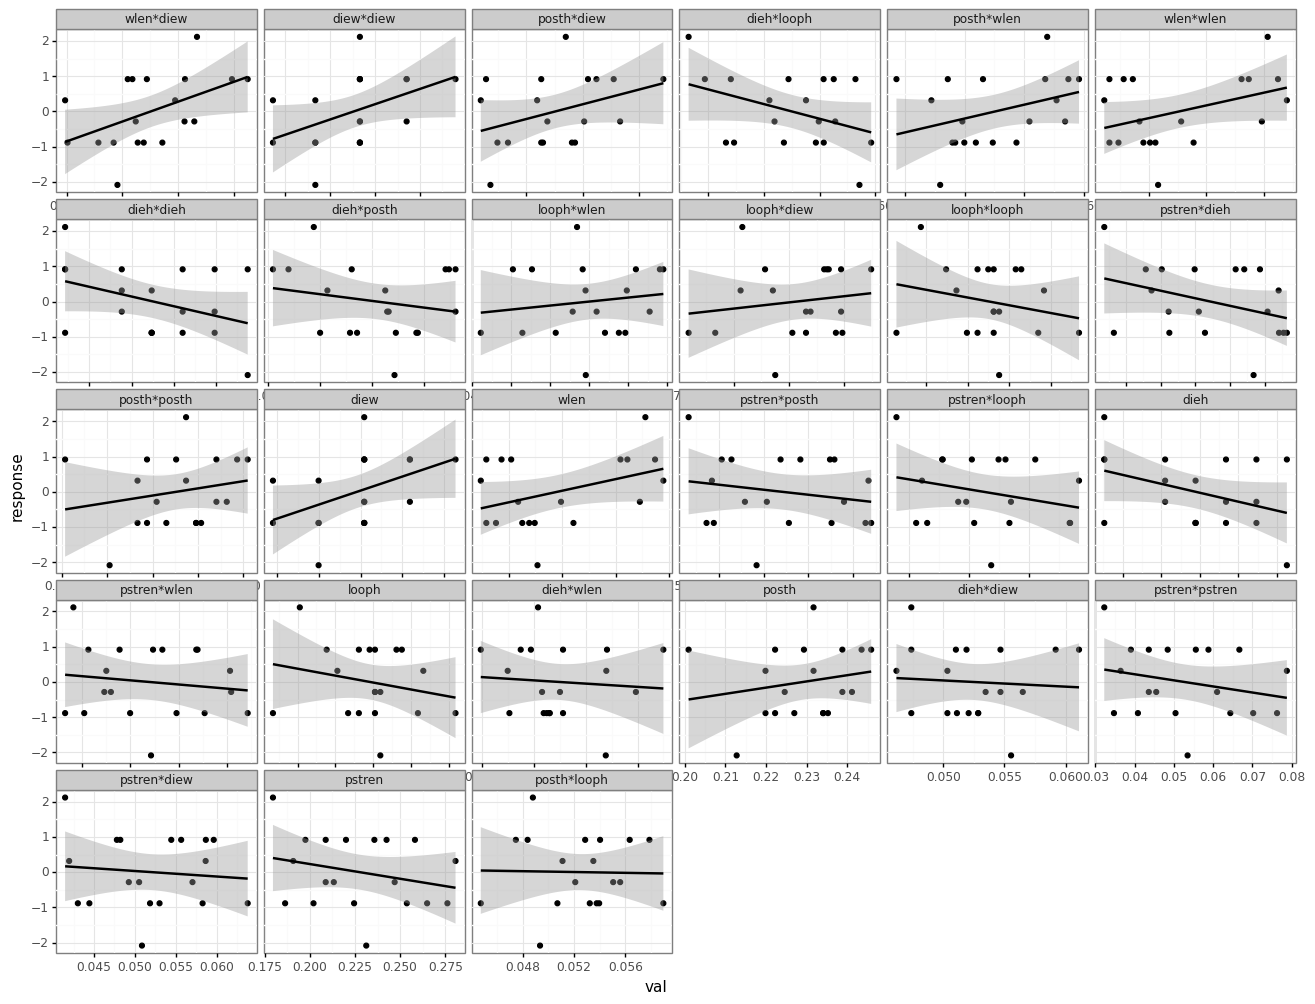

<ggplot: (8789479594852)>

In [436]:
all_data_plot = plot_scatter(plot_df)
all_data_plot

There is one low and one high (`abs(x) > 2`) response, and some of these lines might be mostly driven by them. And the response's high value in those cases are not clearly driven by where they are on the x-axes of these plots. So they might be due to some variation not captured by the variables we have. If so, it's better to choose variables that have main effects even without those two data.

In [432]:
restricted_grids_df = grids_df[grids_df[dm.response].abs() < 2].copy()
restricted_slopes_df = dm.get_linear_slopes(restricted_grids_df)
restricted_plot_df = plot_df[plot_df['response'].abs() < 2].copy()
restricted_plot_df['var'] = pd.Categorical(restricted_plot_df['var'], 
                                           categories=restricted_slopes_df['var'])
restricted_plot_df

,var,val,response
1,pstren,0.186362,-0.884554
2,pstren,0.190852,0.315912
3,pstren,0.197588,0.916145
4,pstren,0.202079,-0.884554
5,pstren,0.208815,0.916145
...,...,...,...
14,diew*diew,0.043641,-0.884554
15,diew*diew,0.053312,0.916145
16,diew*diew,0.048356,-0.884554
17,diew*diew,0.053312,-0.884554


/opt/conda/lib/python3.8/site-packages/plotnine/facets/facet.py:555: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


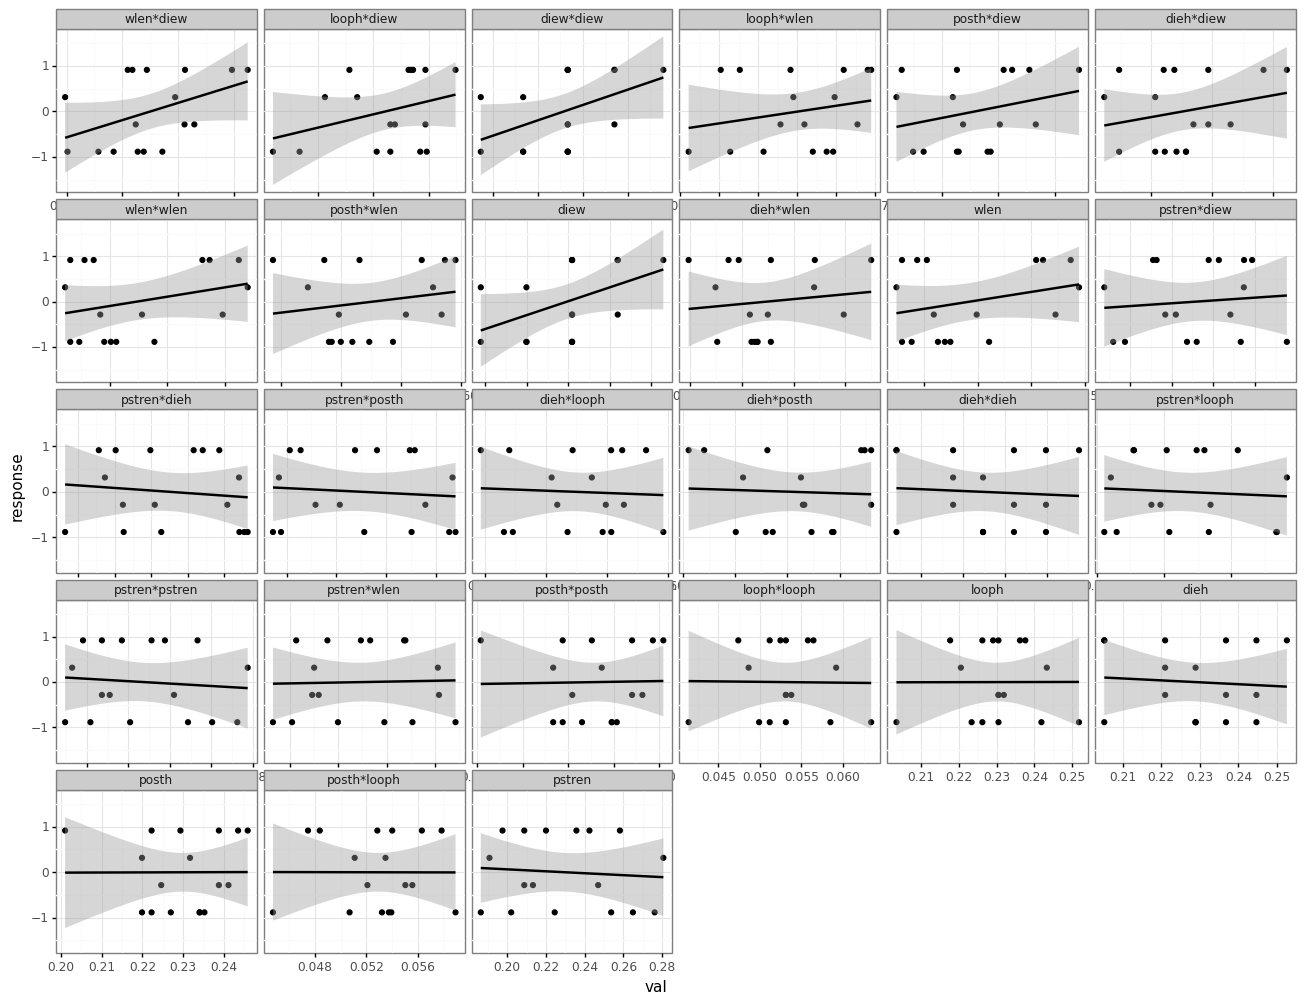

<ggplot: (8789479822448)>

In [433]:
plot_scatter(restricted_plot_df)

So even some of the single variables - like `posth` and `pstren`, on the bottow row - have no alone effect in our data. Let's not bother with them when fitting.

In [476]:
variables = ['wlen*diew', 'looph*diew', 'diew*diew', 'dieh*looph', 'diew', 
             ## has a nice pattern in the non-restricted graph
             'dieh*dieh']
variables = dm.predictors

We'll fit using these predictors:

/opt/conda/lib/python3.8/site-packages/plotnine/facets/facet.py:555: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


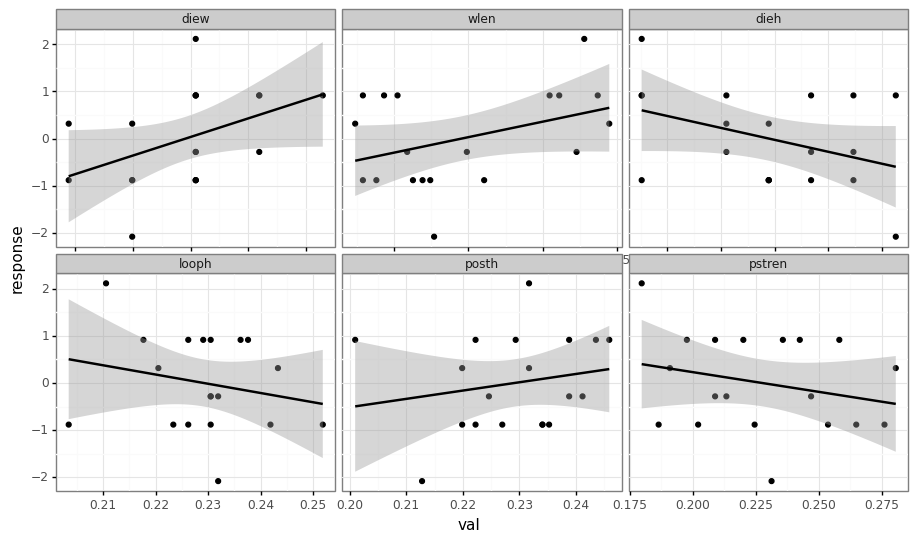

<ggplot: (8789481948733)>

In [477]:
selected_plot_df = plot_df[plot_df['var'].apply(lambda s: s in variables)]
plot_scatter(selected_plot_df, (11, 6))

In [478]:
X = quadratics_wide[variables].values
y = dm.data[dm.response].values

In [479]:
model = LinearRegression().fit(X, y)
pred = model.predict(X)

In [480]:
pred_df = pd.DataFrame(X, columns=variables).assign(y=y, pred=pred, resid=lambda d: d['y'] - d['pred'])
pred_df

,pstren,dieh,posth,looph,wlen,diew,y,pred,resid
0,0.179626,0.205221,0.231706,0.210582,0.245585,0.230895,2.116610,1.021923,1.094687
1,0.186362,0.205221,0.234071,0.230502,0.232129,0.230895,-0.884554,0.074617,-0.959171
2,0.190852,0.228901,0.231706,0.220542,0.248950,0.219900,0.315912,0.129780,0.186132
3,0.197588,0.252580,0.229342,0.230502,0.247397,0.241890,0.916145,0.069408,0.846737
4,0.202079,0.228901,0.219884,0.203468,0.223848,0.219900,-0.884554,-0.048253,-0.836301
5,0.208815,0.205221,0.222249,0.217696,0.218672,0.230895,0.916145,0.337705,0.578439
6,0.208815,0.221007,0.241164,0.230502,0.229800,0.241890,-0.284321,0.238223,-0.522544
7,0.213305,0.236794,0.224613,0.231925,0.221777,0.230895,-0.284321,-0.617062,0.332741
8,0.220041,0.205221,0.245892,0.229079,0.242221,0.252885,0.916145,1.538709,-0.622564
9,0.224532,0.228901,0.235253,0.226233,0.222554,0.230895,-0.884554,-0.175282,-0.709272


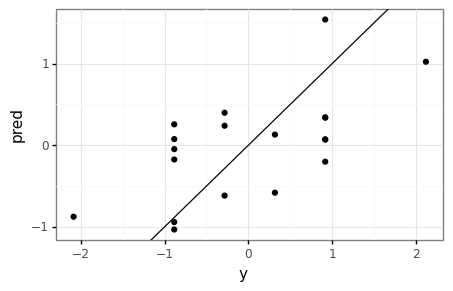

<ggplot: (8789481902044)>

In [481]:
results_figsize = (5, 3)
(pn.ggplot(pred_df, pn.aes(x='y', y='pred')) +
 pn.geom_point() +
 pn.geom_abline(slope=1, intercept=0) + 
 pn.theme_bw() +
 pn.theme(figure_size=results_figsize))

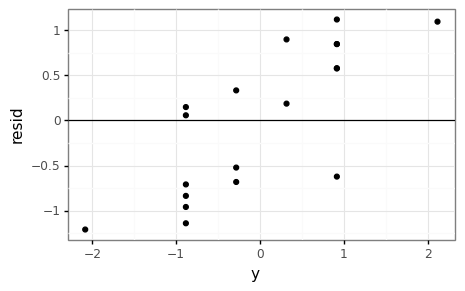

<ggplot: (8789480077993)>

In [482]:
(pn.ggplot(pred_df, pn.aes(x='y', y='resid')) +
 pn.geom_point() +
 pn.geom_hline(yintercept=0) + 
 pn.theme_bw() +
 pn.theme(figure_size=results_figsize))

In [444]:
larger_set_variables = ['pstren', 'dieh', 'posth', 'looph', 'wlen', 'diew', 
                        'wlen*diew', 'diew*diew', 'posth*diew', 'dieh*looph']